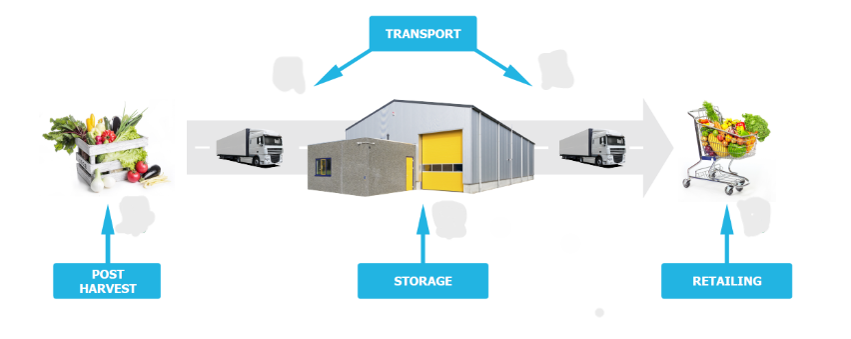

#Context

One of the India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

As a starting point, company has provided us with a dataset scraped from the web which contains train and test folders, each having 4 sub-folders with images of onions, potatoes, tomatoes and some market scenes. Task is to prepare a multiclass classifier for identifying these vegetables. The dataset provided has all the required images to achieve the task.

#Know Your Data

## Setup Data Paths

In [ ]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=41173037-3bb1-456e-a9e3-83a207326a33
To: /content/ninjacart_data.zip
100% 275M/275M [00:03<00:00, 80.6MB/s]


In [ ]:
!unzip -q ninjacart_data.zip

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = '/content/ninjacart_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## Class Distribution


Image count per class in train set class distribution:
onion: 849
potato: 898
tomato: 789
indian market: 599


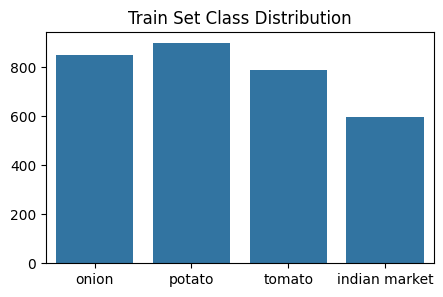


Image count per class in test set class distribution:
onion: 83
potato: 81
tomato: 106
indian market: 81


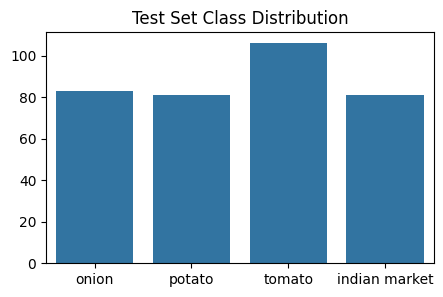

In [ ]:
# Function to print and plot class distribution
def plot_class_distribution(data_dir, title='Class Distribution'):
    class_counts = {}
    for label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, label)
        class_counts[label] = len(os.listdir(class_path))

    # Print the class counts
    print(f"\nImage count per class in {title.lower()}:")
    for label, count in class_counts.items():
        print(f"{label}: {count}")

    # Plot
    plt.figure(figsize=(5,3))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.show()

# For training data
plot_class_distribution(train_dir, title='Train Set Class Distribution')

# For test data
plot_class_distribution(test_dir, title='Test Set Class Distribution')

- Image count per class in train set class distribution is found to be:

  onion: 849,
potato: 898,
indian market: 599,
tomato: 789

- Image count per class in test set class distribution:

  onion: 83,
potato: 81,
indian market: 81,
tomato: 106

## Visualize Sample Images

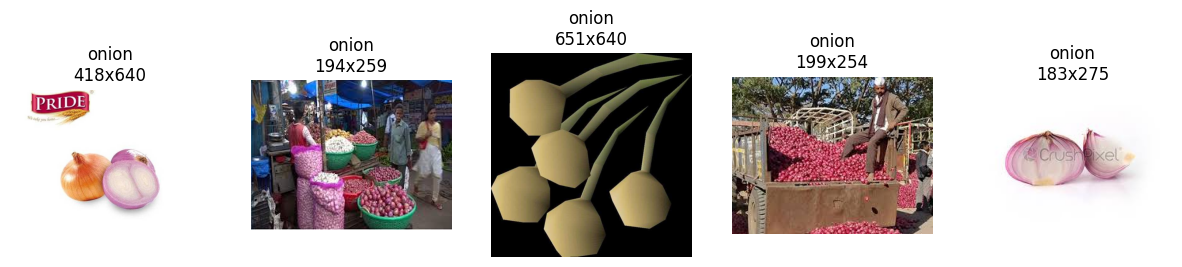

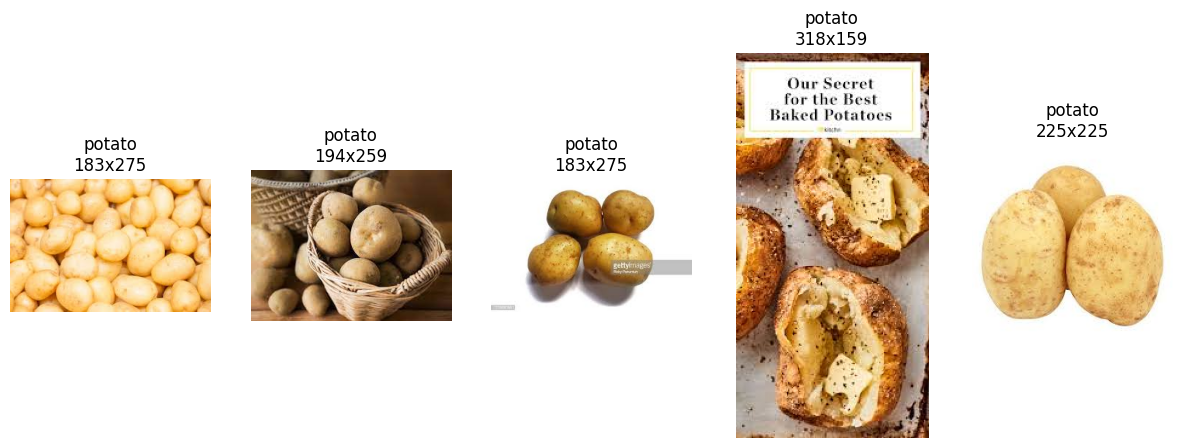

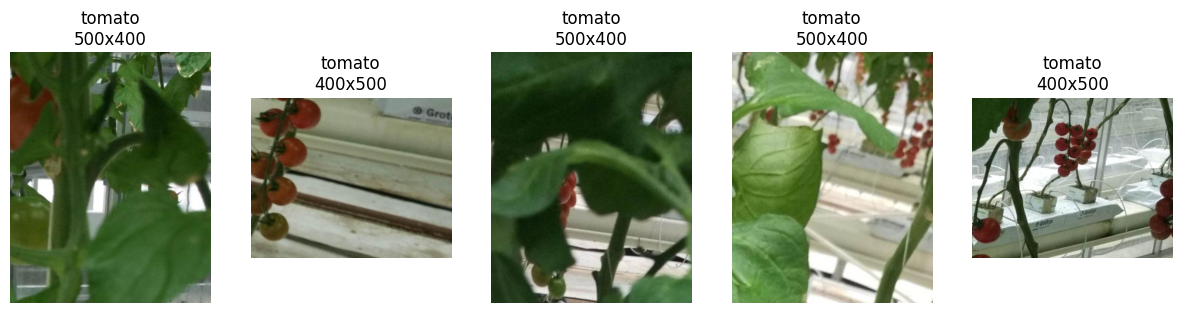

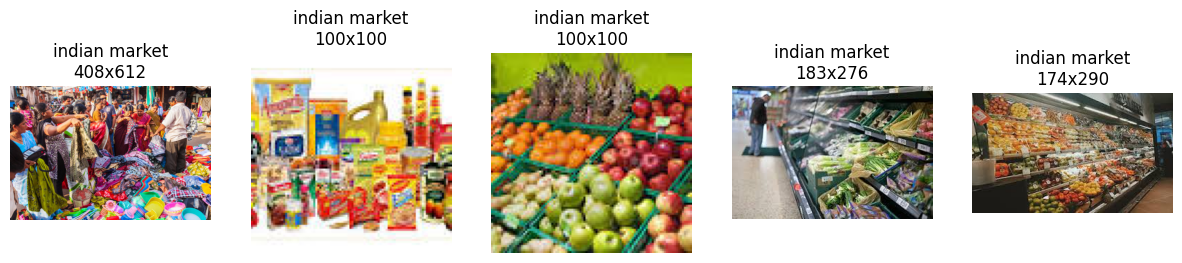

In [ ]:
def show_images(data_dir, class_name, n=5):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)[:n]
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(images):
        img = plt.imread(os.path.join(class_path, img_file))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img.shape[0]}x{img.shape[1]}")
        plt.axis('off')
    plt.show()

for class_name in os.listdir(train_dir):
    show_images(train_dir, class_name)

- Sample images for each class look pretty much matching with the category.
- Dimensions for images in each category are different.
- Will perform further analysis on dimensions in next segment to get more details regarding the data.

##Image Dimensions Analysis

In [ ]:
import cv2

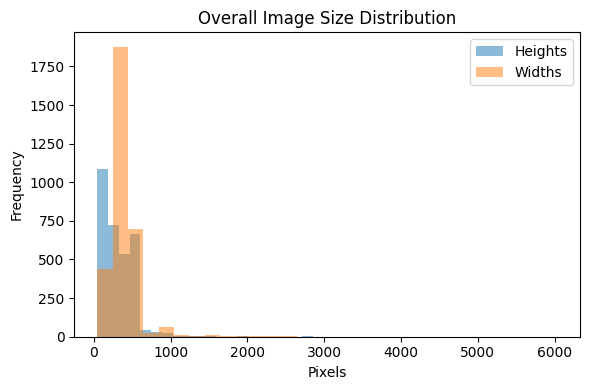

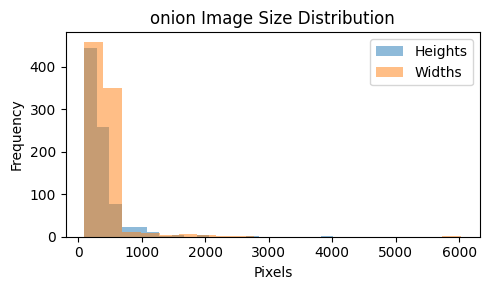

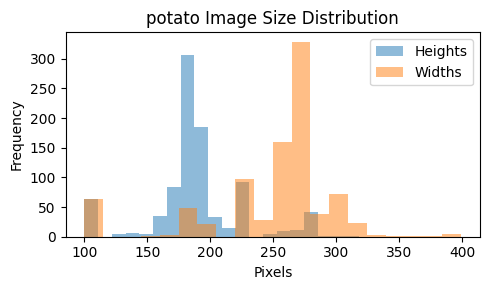

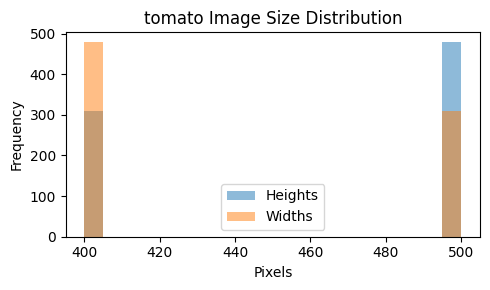

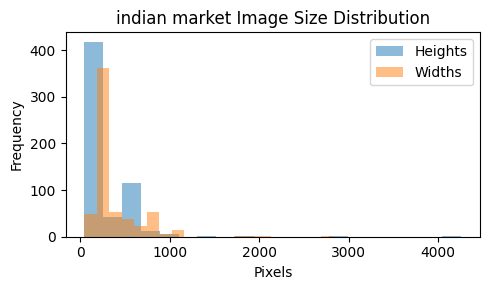

In [ ]:
def analyze_image_shapes(data_dir):
    shapes = []
    per_class_shapes = {}

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_shapes = []
        for file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, file))
            if img is not None:
                shape = img.shape[:2]
                shapes.append(shape)
                class_shapes.append(shape)
        per_class_shapes[class_name] = class_shapes

    # Overall image size distribution
    heights, widths = zip(*shapes)
    plt.figure(figsize=(6, 4))
    plt.hist(heights, bins=30, alpha=0.5, label='Heights')
    plt.hist(widths, bins=30, alpha=0.5, label='Widths')
    plt.legend()
    plt.title('Overall Image Size Distribution')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Per class image size distribution
    for class_name, shapes in per_class_shapes.items():
        if shapes:
            heights, widths = zip(*shapes)
            plt.figure(figsize=(5, 3))
            plt.hist(heights, bins=20, alpha=0.5, label='Heights')
            plt.hist(widths, bins=20, alpha=0.5, label='Widths')
            plt.legend()
            plt.title(f'{class_name} Image Size Distribution')
            plt.xlabel('Pixels')
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()

analyze_image_shapes(train_dir)

- Overall Image Size Distribution:
  - Most of the images (more than 1000 images) have a height of 100-200 pixels
  - Nearly 2000 images have a width between 400-500 pixel
- Onion Images Size Distribution:
  - Most of the images (nearly 450) have a width and height of 100-200 pixels
- Potato Images Size Distribution:
  - Most of the potato images (around 300 images) have a height of around 175 pixels.
  - Maximum images (around 325 images) have a width of 275 pixels
- Indian Market Images Size Distribution:
  - More than 400 images have a height of 100-200 pixels
  - Around 350 images have a width of around 300-400 pixels
- Tomato Images Size Distribution:
  - All the tomato images have height and width of either 400 pixel or 500 pixel
  - Nearly 500 images have a height of 500 pixel
  - Nearly 500 images have a width of 400 pixel

#Data Generators / Data Augmentation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


- Training Data: Found 2511 images belonging to 4 classes.
- Validation Data: Found 624 images belonging to 4 classes.
- Test Data: Found 351 images belonging to 4 classes.
- Data Augmentation is performed through rescale, horizontal_flip to artificially expand training dataset by creating new, slightly modified versions of the existing images. This helps model to generalize better and reduces overfitting.

#Compute Class Weights

In [ ]:
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.3078125), 1: np.float64(0.9231617647058824), 2: np.float64(0.8730876216968011), 3: np.float64(0.9932753164556962)}


- Class Imbalance is not severe but still exists. class_weight is used to penalize the model more for mistakes on minority classes.

#Define Baseline CNN Model

In [ ]:
def build_baseline_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

- The baseline model is a custom CNN composed of two convolutional blocks followed by dense layers. While simpler than pretrained networks, it provides a clear benchmark for assessing the improvements brought by transfer learning. The use of BatchNormalization and Dropout helps regularize the network, and the final softmax layer outputs class probabilities for the 4 target classes.

#Define Transfer Learning Model

In [ ]:
def build_transfer_model(base_model):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

- The transfer model leverages the power of pretrained networks to extract generic image features and layers a lightweight classifier on top. This hybrid approach reduces the need for extensive training data while improving generalization. Freezing the convolutional base ensures stability in feature extraction, and the addition of dropout and global average pooling makes the model efficient and less prone to overfitting.

#Setup Callbacks

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    TensorBoard(log_dir=log_dir)
]

- Callbacks are configured to optimize training runtime, avoid overfitting, and retain the best-performing model checkpoint. The use of early stopping and model checkpointing ensured efficient convergence, while TensorBoard offered rich visualization support for debugging and performance analysis.

#Train and Evaluate all Models

In [ ]:
all_histories = {}
val_scores = {}

# Baseline CNN
baseline_model = build_baseline_model()
baseline_history = baseline_model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks, class_weight=class_weights_dict)
val_scores['Baseline CNN'] = baseline_history.history['val_accuracy'][-1]
all_histories['Baseline CNN'] = (baseline_model, baseline_history)

# VGG16
vgg_model = build_transfer_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
vgg_history = vgg_model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks, class_weight=class_weights_dict)
val_scores['VGG16'] = vgg_history.history['val_accuracy'][-1]
all_histories['VGG16'] = (vgg_model, vgg_history)

# ResNet50
resnet_model = build_transfer_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
resnet_history = resnet_model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks, class_weight=class_weights_dict)
val_scores['ResNet50'] = resnet_history.history['val_accuracy'][-1]
all_histories['ResNet50'] = (resnet_model, resnet_history)

# MobileNetV2
mobilenet_model = build_transfer_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
mobilenet_history = mobilenet_model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks, class_weight=class_weights_dict)
val_scores['MobileNetV2'] = mobilenet_history.history['val_accuracy'][-1]
all_histories['MobileNetV2'] = (mobilenet_model, mobilenet_history)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6541 - loss: 23.9487

79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 601ms/step - accuracy: 0.6547 - loss: 23.9102 - val_accuracy: 0.2708 - val_loss: 15.2154
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7453 - loss: 13.3147

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 532ms/step - accuracy: 0.7453 - loss: 13.2903 - val_accuracy: 0.4792 - val_loss: 10.4629
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 519ms/step - accuracy: 0.7504 - loss: 5.7626 - val_accuracy: 0.2516 - val_loss: 41.0403
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 529ms/step - accuracy: 0.7766 - loss: 2.5893 - val_accuracy: 0.2708 - val_loss: 20.4500
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7690 - loss: 1.9656

79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 597ms/step - accuracy: 0.7690 - loss: 1.9657 - val_accuracy: 0.3766 - val_loss: 4.0424
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7843 - loss: 0.9118

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 537ms/step - accuracy: 0.7842 - loss: 0.9109 - val_accuracy: 0.5048 - val_loss: 3.1147
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7855 - loss: 0.7132

79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 588ms/step - accuracy: 0.7854 - loss: 0.7127 - val_accuracy: 0.6522 - val_loss: 1.2823
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7945 - loss: 0.5728

79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 617ms/step - accuracy: 0.7945 - loss: 0.5726 - val_accuracy: 0.7388 - val_loss: 0.7806
Epoch 9/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8071 - loss: 0.6185

79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 541ms/step - accuracy: 0.8070 - loss: 0.6183 - val_accuracy: 0.7660 - val_loss: 0.6522
Epoch 10/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8245 - loss: 0.4761

79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 603ms/step - accuracy: 0.8244 - loss: 0.4769 - val_accuracy: 0.7676 - val_loss: 0.4777
Epoch 11/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 516ms/step - accuracy: 0.8103 - loss: 0.4933 - val_accuracy: 0.7628 - val_loss: 0.7098
Epoch 12/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 530ms/step - accuracy: 0.8244 - loss: 0.4435 - val_accuracy: 0.7837 - val_loss: 0.7826
Epoch 13/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 520ms/step - accuracy: 0.8293 - loss: 0.5500 - val_accuracy: 0.7580 - val_loss: 0.8609
Epoch 14/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 555ms/step - accuracy: 0.8128 - loss: 0.5133 - val_accuracy: 0.7724 - val_loss: 0.5287
Epoch 15/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - accuracy: 0.8371 - loss: 0.4053 - val_accuracy: 0.7500 - val_loss: 0.7973
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 773ms/step - accuracy: 0.3514 - loss: 1.4216 - val_accuracy: 0.7308 - val_loss: 0.9605
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 577ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 586ms/step - accuracy: 0.8014 - loss: 0.5218 - val_accuracy: 0.8590 - val_loss: 0.4757
Epoch 9/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8078 - loss: 0.5106

79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 579ms/step - accuracy: 0.8079 - loss: 0.5105 - val_accuracy: 0.8317 - val_loss: 0.4607
Epoch 10/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8184 - loss: 0.4904

79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 576ms/step - accuracy: 0.8185 - loss: 0.4903 - val_accuracy: 0.8526 - val_loss: 0.4483
Epoch 11/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8201 - loss: 0.4665

79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 730ms/step - accuracy: 0.8201 - loss: 0.4666 - val_accuracy: 0.8622 - val_loss: 0.4335
Epoch 12/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8393 - loss: 0.4443

79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 590ms/step - accuracy: 0.8392 - loss: 0.4444 - val_accuracy: 0.8542 - val_loss: 0.4185
Epoch 13/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8338 - loss: 0.4562

79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 584ms/step - accuracy: 0.8338 - loss: 0.4561 - val_accuracy: 0.8606 - val_loss: 0.4082
Epoch 14/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 573ms/step - accuracy: 0.8379 - loss: 0.4365 - val_accuracy: 0.8526 - val_loss: 0.4093
Epoch 15/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8132 - loss: 0.4594

79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 584ms/step - accuracy: 0.8134 - loss: 0.4591 - val_accuracy: 0.8606 - val_loss: 0.4053
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 690ms/step - accuracy: 0.3005 - loss: 1.5726 - val_accuracy: 0.4231 - val_loss: 1.2791
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 557ms/step - accuracy: 0.3652 - loss: 1.3098 - val_accuracy: 0.4567 - val_loss: 1.2575
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 544ms/step - accuracy: 0.3807 - loss: 1.2614 - val_accuracy: 0.4712 - val_loss: 1.2268
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 555ms/step - accuracy: 0.4466 - loss: 1.2088 - val_accuracy: 0.4263 - val_loss: 1.2130
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 572ms/step - accuracy: 0.4479 - loss: 1.1968 - val_accuracy: 0.4888 - val_loss: 1.1810
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 558ms/step - accuracy: 0.4604 - loss: 1.1688 - val_accuracy: 0.4679 - val_loss: 1.1743
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 560ms/step - ac

79/79 ━━━━━━━━━━━━━━━━━━━━ 61s 655ms/step - accuracy: 0.5743 - loss: 1.0942 - val_accuracy: 0.9022 - val_loss: 0.2761
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8910 - loss: 0.2681

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 527ms/step - accuracy: 0.8912 - loss: 0.2678 - val_accuracy: 0.9279 - val_loss: 0.2099
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9174 - loss: 0.2183

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 519ms/step - accuracy: 0.9176 - loss: 0.2180 - val_accuracy: 0.9423 - val_loss: 0.1732
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.9350 - loss: 0.1630 - val_accuracy: 0.9439 - val_loss: 0.1748
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9429 - loss: 0.1496

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 532ms/step - accuracy: 0.9429 - loss: 0.1496 - val_accuracy: 0.9519 - val_loss: 0.1574
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9445 - loss: 0.1306

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 523ms/step - accuracy: 0.9446 - loss: 0.1306 - val_accuracy: 0.9535 - val_loss: 0.1386
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 516ms/step - accuracy: 0.9609 - loss: 0.1063 - val_accuracy: 0.9583 - val_loss: 0.1492
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.9647 - loss: 0.0935 - val_accuracy: 0.9487 - val_loss: 0.1426
Epoch 9/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - accuracy: 0.9588 - loss: 0.1030 - val_accuracy: 0.9471 - val_loss: 0.1583
Epoch 10/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9671 - loss: 0.0925

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 533ms/step - accuracy: 0.9671 - loss: 0.0925 - val_accuracy: 0.9583 - val_loss: 0.1286
Epoch 11/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 515ms/step - accuracy: 0.9667 - loss: 0.0790 - val_accuracy: 0.9519 - val_loss: 0.1316
Epoch 12/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9601 - loss: 0.1015

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 522ms/step - accuracy: 0.9601 - loss: 0.1014 - val_accuracy: 0.9503 - val_loss: 0.1276
Epoch 13/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 527ms/step - accuracy: 0.9680 - loss: 0.0908 - val_accuracy: 0.9487 - val_loss: 0.1453
Epoch 14/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.9664 - loss: 0.0917 - val_accuracy: 0.9423 - val_loss: 0.1491
Epoch 15/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 552ms/step - accuracy: 0.9718 - loss: 0.0890 - val_accuracy: 0.9487 - val_loss: 0.1278


- A structured comparison was performed between a baseline CNN and three transfer learning models (VGG16, ResNet50, MobileNetV2). Uniform training conditions ensured fairness, allowing validation accuracy to be used as the key metric for selecting the best-performing architecture.

In [ ]:
# Print val accuracy and val loss for each model
print("Model Comparison (Validation Accuracy & Loss):\n")
for model_name, (model, history) in all_histories.items():
    val_acc = val_scores[model_name]
    val_loss = history.history['val_loss'][-1]
    print(f"{model_name} - Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

Model Comparison (Validation Accuracy & Loss):

Baseline CNN - Val Accuracy: 0.7500, Val Loss: 0.7973
VGG16 - Val Accuracy: 0.8606, Val Loss: 0.4053
ResNet50 - Val Accuracy: 0.4888, Val Loss: 1.1261
MobileNetV2 - Val Accuracy: 0.9487, Val Loss: 0.1278


- Model Comparison (Validation Accuracy & Loss):

  Baseline CNN - Val Accuracy: 0.7500, Val Loss: 0.7973

  VGG16 - Val Accuracy: 0.8606, Val Loss: 0.4053

  ResNet50 - Val Accuracy: 0.4888, Val Loss: 1.1261

  MobileNetV2 - Val Accuracy: 0.9487, Val Loss: 0.1278

#Plot Accuracy and Loss of all Models

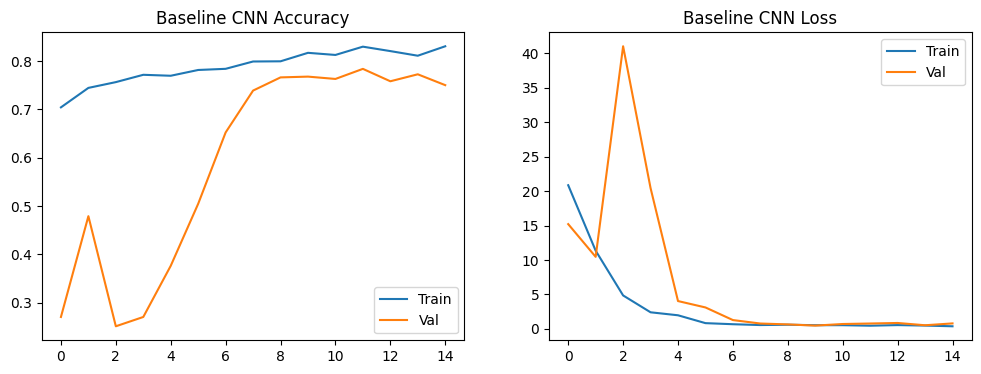

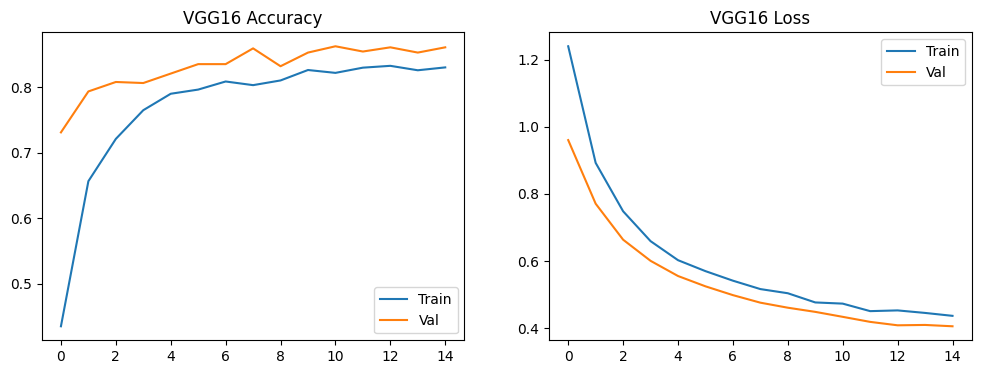

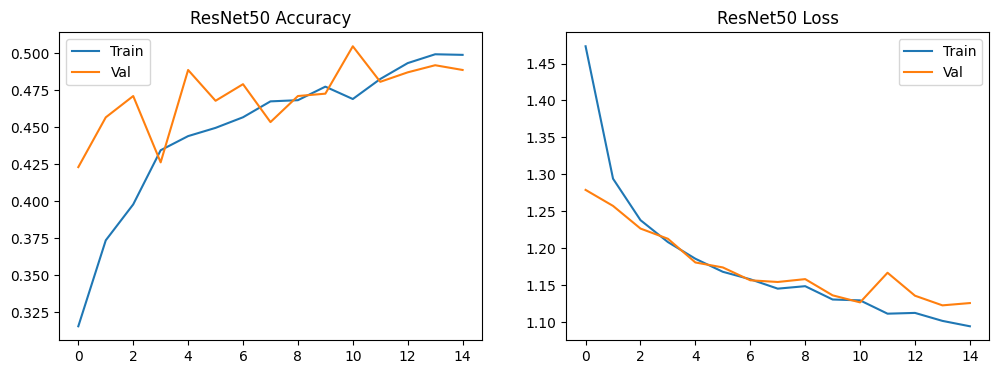

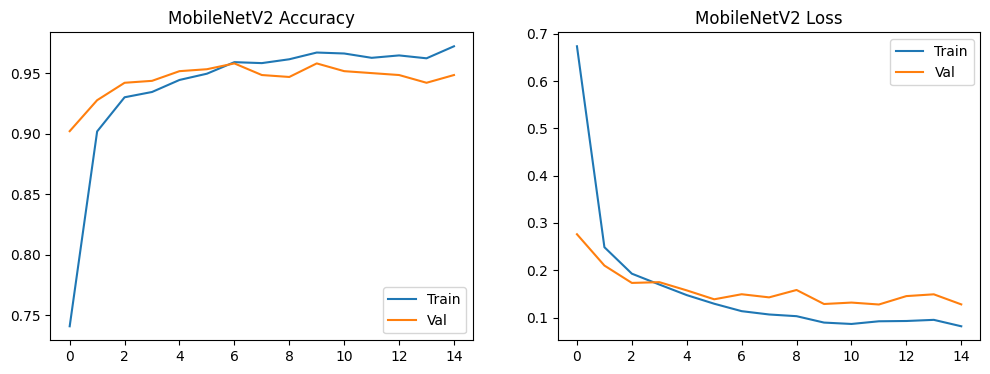

In [ ]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

for model_name, (model, history) in all_histories.items():
    plot_training_history(history, model_name)

- It is clear through all accuracy and loss plots that Mobilenetv2 has got maximum val_accuracy of 95% and minimum val_loss of 0.1278

#Evaluate Best Model

Best model based on validation accuracy: MobileNetV2
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8858 - loss: 0.2868
Test Accuracy: 0.91
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


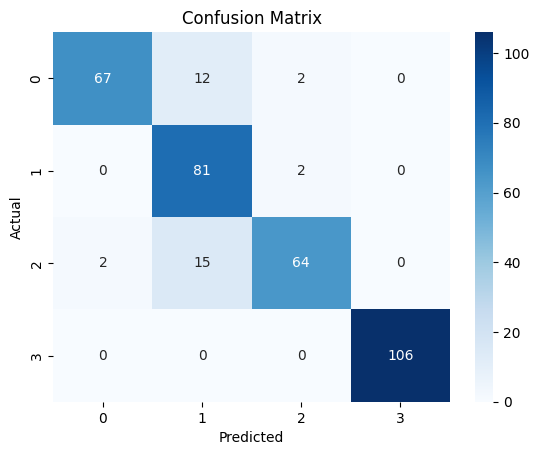

               precision    recall  f1-score   support

indian market       0.97      0.83      0.89        81
        onion       0.75      0.98      0.85        83
       potato       0.94      0.79      0.86        81
       tomato       1.00      1.00      1.00       106

     accuracy                           0.91       351
    macro avg       0.92      0.90      0.90       351
 weighted avg       0.92      0.91      0.91       351



In [ ]:
best_model_name= max(val_scores, key=val_scores.get)
print(f"Best model based on validation accuracy: {best_model_name}")

best_model = all_histories[best_model_name][0]
loss, acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.2f}")

preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

Classification report of the MobileNetV2 model, which achieved 91% overall accuracy:

✅ Strengths

- Tomato classification is perfect, with precision, recall, and F1-score all at 1.00.

- Indian Market class has excellent precision (0.97), meaning almost all predicted noise images are correct.

- High F1-scores across all classes (≥ 0.85) show strong balance between precision and recall.

- Model generalizes well, with macro and weighted averages close to 0.91.

⚠️ Areas to Monitor

- Indian Market recall (0.83) suggests some market images are being misclassified as vegetables — could be due to complex backgrounds or overlaps.

- Onion precision (0.75) is the lowest, meaning some predictions of “onion” are false positives — possibly confused with similarly shaped vegetables like potatoes.

#Confusion Matrix / Classification Reports

351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


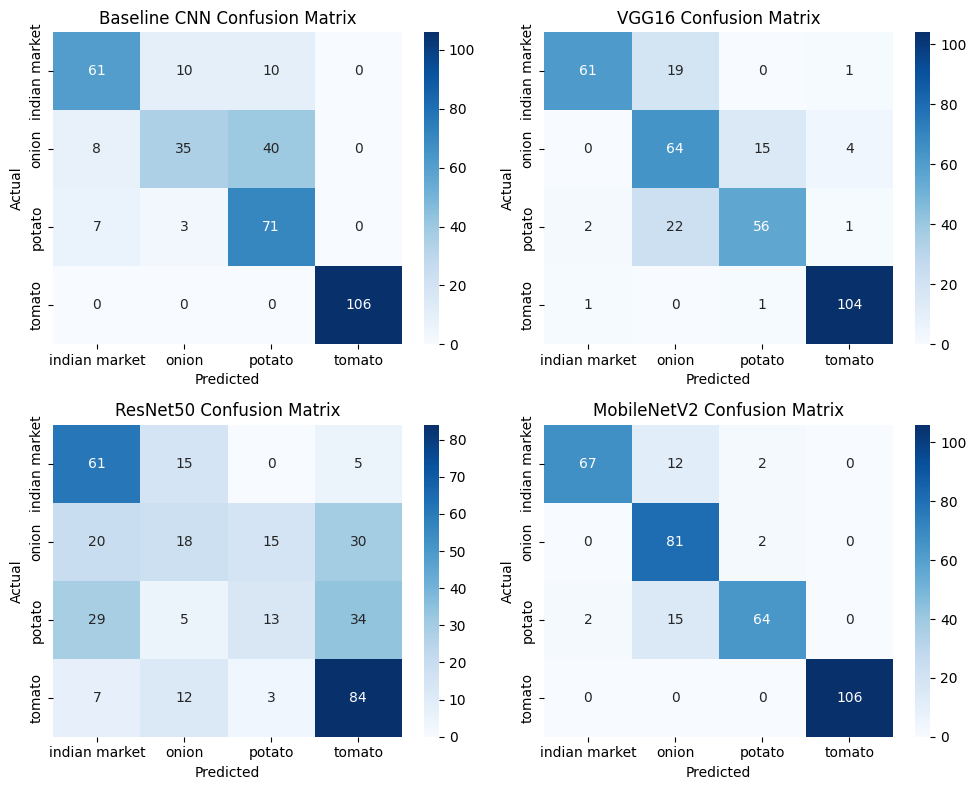

In [ ]:
# List of model names and their corresponding models
models = {
    "Baseline CNN": all_histories["Baseline CNN"][0],
    "VGG16": all_histories["VGG16"][0],
    "ResNet50": all_histories["ResNet50"][0],
    "MobileNetV2": all_histories["MobileNetV2"][0]
}

# Get the true labels from the test data
y_true = test_gen.classes

# Initialize plot for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Loop through models and generate confusion matrix
for idx, (model_name, model) in enumerate(models.items()):
    # Get predictions for the model
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix for the model
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys())
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
# Loop through models and generate classification report
for model_name, model in models.items():
    # Get predictions for the model
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys())
    print(f"\nClassification Report for {model_name}:\n")
    print(report)

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Classification Report for Baseline CNN:

               precision    recall  f1-score   support

indian market       0.80      0.75      0.78        81
        onion       0.73      0.42      0.53        83
       potato       0.59      0.88      0.70        81
       tomato       1.00      1.00      1.00       106

     accuracy                           0.78       351
    macro avg       0.78      0.76      0.75       351
 weighted avg       0.80      0.78      0.77       351

351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

Classification Report for VGG16:

               precision    recall  f1-score   support

indian market       0.95      0.75      0.84        81
        onion       0.61      0.77      0.68        83
       potato       0.78      0.69      0.73        81
       tomato       0.95      0.98      0.96       106

     accuracy                           0.81       351
    macro avg       0.82      0.80      0.80       351
 weighted 

📋 Insights from Classification Reports.

Each model’s classification performance was assessed using precision, recall, and F1-score for all four classes: indian market, onion, potato, and tomato. The following patterns emerged:

✅ MobileNetV2 (Best Overall Performance)
Accuracy: 91%

Demonstrated excellent balance across all classes.

Especially strong for:

Tomato (F1 = 1.00)

Onion (F1 = 0.85) and Potato (F1 = 0.86), which are typically harder to distinguish.

Insight: MobileNetV2's lightweight architecture combined with pretrained weights is well-suited for fine-tuned vegetable classification.

⚠️ VGG16 (Moderate Performance)
Accuracy: 81%

High performance for Tomato (F1 = 0.96) and Indian Market (F1 = 0.84), but less reliable for Onion (F1 = 0.68).

Insight: While better than the baseline, VGG16 struggled with inter-class confusion between vegetables, likely due to similar texture/shape features.

🧱 Baseline CNN (Reasonable Simplicity)
Accuracy: 78%

Very strong on Tomato (F1 = 1.00), but poor recall for Onion (0.42).

Insight: The model overfit to dominant patterns (e.g., Tomato) but failed on subtler differences, confirming the need for deeper or pretrained architectures.

❌ ResNet50 (Underperformance)
Accuracy: 50%

All classes except Tomato (F1 = 0.65) showed weak recall, especially:

Onion (F1 = 0.27)

Potato (F1 = 0.23)

Insight: ResNet50 might have required fine-tuning instead of freezing the base layers. Transfer learning without unfreezing may have prevented it from adapting effectively.



#Random Test Images with Predictions

In [ ]:
import random

In [ ]:
class_labels = list(test_gen.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


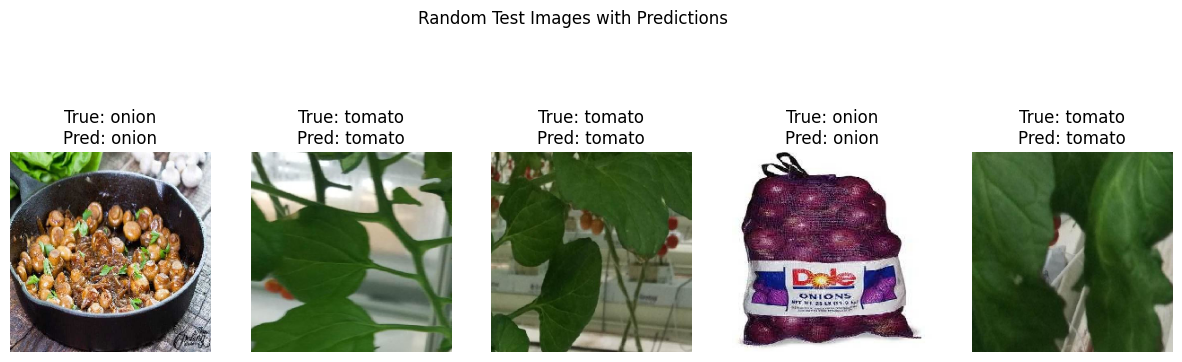

In [ ]:
# Access image file paths and true labels
file_paths = test_gen.filepaths
true_labels = test_gen.classes

# Randomly select 5 test image indices
random_indices = random.sample(range(len(file_paths)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    img_path = file_paths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = best_model.predict(img_array_exp)
    pred_label = class_labels[np.argmax(prediction)]

    # True label
    true_label = class_labels[true_labels[idx]]

    # Plot
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("Random Test Images with Predictions")
plt.show()

- Checked 5 random images from the test set and found that the true label matches the predicted label for all 5 of them

#Summary / Insights

- Image count per class in train set class distribution is found to be:

  onion: 849, potato: 898, indian market: 599, tomato: 789

- Image count per class in test set class distribution:

  onion: 83, potato: 81, indian market: 81, tomato: 106

- Sample images for each class look pretty much matching with the category.
- Dimensions for images in each category are different.
- Overall Image Size Distribution:
  - Most of the images (more than 1000 images) have a height of 100-200 pixels
  - Nearly 2000 images have a width between 400-500 pixel
- Onion Images Size Distribution:
  - Most of the images (nearly 450) have a width and height of 100-200 pixels
- Potato Images Size Distribution:
  - Most of the potato images (around 300 images) have a height of around 175 pixels.
  - Maximum images (around 325 images) have a width of 275 pixels
- Indian Market Images Size Distribution:
  - More than 400 images have a height of 100-200 pixels
  - Around 350 images have a width of around 300-400 pixels
- Tomato Images Size Distribution:
  - All the tomato images have height and width of either 400 pixel or 500 pixel
  - Nearly 500 images have a height of 500 pixel
  - Nearly 500 images have a width of 400 pixel
- Training Data: Found 2511 images belonging to 4 classes.
- Validation Data: Found 624 images belonging to 4 classes.
- Test Data: Found 351 images belonging to 4 classes.
- Data Augmentation is performed through rescale, horizontal_flip to artificially expand training dataset by creating new, slightly modified versions of the existing images. This helps model to generalize better and reduces overfitting.
- Class Imbalance is not severe but still exists. class_weight is used to penalize the model more for mistakes on minority classes.
- The baseline model is a custom CNN composed of two convolutional blocks followed by dense layers. While simpler than pretrained networks, it provides a clear benchmark for assessing the improvements brought by transfer learning. The use of BatchNormalization and Dropout helps regularize the network, and the final softmax layer outputs class probabilities for the 4 target classes.
- The transfer model leverages the power of pretrained networks to extract generic image features and layers a lightweight classifier on top. This hybrid approach reduces the need for extensive training data while improving generalization. Freezing the convolutional base ensures stability in feature extraction, and the addition of dropout and global average pooling makes the model efficient and less prone to overfitting.
- Callbacks are configured to optimize training runtime, avoid overfitting, and retain the best-performing model checkpoint. The use of early stopping and model checkpointing ensured efficient convergence, while TensorBoard offered rich visualization support for debugging and performance analysis.
- A structured comparison was performed between a baseline CNN and three transfer learning models (VGG16, ResNet50, MobileNetV2). Uniform training conditions ensured fairness, allowing validation accuracy to be used as the key metric for selecting the best-performing architecture.
- It is clear through all accuracy and loss plots that Mobilenetv2 has got maximum val_accuracy of 95% and minimum val_loss of 0.1278
Classification report of the MobileNetV2 model, which achieved 91% overall accuracy:

✅ Strengths

- Tomato classification is perfect, with precision, recall, and F1-score all at 1.00.

- Indian Market class has excellent precision (0.97), meaning almost all predicted noise images are correct.

- High F1-scores across all classes (≥ 0.85) show strong balance between precision and recall.

- Model generalizes well, with macro and weighted averages close to 0.91.

⚠️ Areas to Monitor

- Indian Market recall (0.83) suggests some market images are being misclassified as vegetables — could be due to complex backgrounds or overlaps.

- Onion precision (0.75) is the lowest, meaning some predictions of “onion” are false positives — possibly confused with similarly shaped vegetables like potatoes.

📋 Insights from Classification Reports.

Each model’s classification performance was assessed using precision, recall, and F1-score for all four classes: indian market, onion, potato, and tomato. The following patterns emerged:

✅ MobileNetV2 (Best Overall Performance)
Accuracy: 91%

Demonstrated excellent balance across all classes.

Especially strong for:

Tomato (F1 = 1.00)

Onion (F1 = 0.85) and Potato (F1 = 0.86), which are typically harder to distinguish.

Insight: MobileNetV2's lightweight architecture combined with pretrained weights is well-suited for fine-tuned vegetable classification.

⚠️ VGG16 (Moderate Performance)
Accuracy: 81%

High performance for Tomato (F1 = 0.96) and Indian Market (F1 = 0.84), but less reliable for Onion (F1 = 0.68).

Insight: While better than the baseline, VGG16 struggled with inter-class confusion between vegetables, likely due to similar texture/shape features.

🧱 Baseline CNN (Reasonable Simplicity)
Accuracy: 78%

Very strong on Tomato (F1 = 1.00), but poor recall for Onion (0.42).

Insight: The model overfit to dominant patterns (e.g., Tomato) but failed on subtler differences, confirming the need for deeper or pretrained architectures.

❌ ResNet50 (Underperformance)
Accuracy: 50%

All classes except Tomato (F1 = 0.65) showed weak recall, especially:

Onion (F1 = 0.27)

Potato (F1 = 0.23)

Insight: ResNet50 might have required fine-tuning instead of freezing the base layers. Transfer learning without unfreezing may have prevented it from adapting effectively.
- Checked 5 random images from the test set and found that the true label matches the predicted label for all 5 of them



# 📌 Strategic Recommendations for Stakeholders

Based on the insights from the classification project using baseline CNN and transfer learning models, following are the recommendations.

---

### ✅ 1. Adopt MobileNetV2 for Production Deployment
- **Why:** Achieved **91% accuracy** with excellent balance across all classes.
- **Highlights:**
  - Perfect classification for **tomatoes** (F1 = 1.00).
  - High F1-scores for onion (0.85) and potato (0.86).
- **Business Impact:** Enables highly reliable **automated vegetable sorting** and **quality assurance**.
- **Next Step:** Freeze the MobileNetV2 model version and integrate it into the operational pipeline.

---

### 🎯 2. Improve Model Recall for 'Indian Market' Class
- **Why:** Recall is **0.83**, indicating some **noise images are being misclassified** as vegetables.
- **Business Impact:** May lead to **false positives** in vegetable detection.
- **Recommendations:**
  - Include more **complex, cluttered 'Indian Market' samples**.
  - Introduce **synthetic noise/backgrounds** during training.
  - Explore **domain-specific data augmentation** for background variation.

---

### 🧅 3. Boost Precision for Onion Classification
- **Why:** Onion precision is **0.75**, showing some confusion with potatoes.
- **Business Impact:** Risk of **sorting or labeling errors** between similar-looking vegetables.
- **Recommendations:**
  - Collect more **high-quality onion images** with distinct features.
  - Apply **image enhancement techniques** like sharpening or contrast normalization.
  - Perform **targeted fine-tuning** for onion vs. potato classification.

---

### 🧪 4. Refine Image Input Standards
- **Why:** Significant variation in image dimensions across classes.
  - Tomato images are mostly 400–500px.
  - Onion images mostly 100–200px.
- **Business Impact:** Could lead to **inconsistent model performance** and higher preprocessing cost.
- **Recommendations:**
  - Standardize all images to **224x224 pixels** before training/inference.
  - Optimize **camera settings or preprocessing pipelines** to unify dimensions.

---

### 🔍 5. Continue Model Monitoring and Validation
- **Why:** Some performance gaps remain, especially for onion and noise images.
- **Business Impact:** Prevents **unexpected drops in accuracy** in production.
- **Recommendations:**
  - Periodically validate predictions with **manual spot checks**.
  - Set up a **feedback loop** to collect and retrain on misclassified images.
  - Use tools like **TensorBoard** to monitor metrics over time.

---

### ❌ 6. Avoid ResNet50 for Similar Use Cases
- **Why:** Showed **poor performance** (50% accuracy), especially on onions and potatoes.
- **Insight:** ResNet50 may require **unfreezing and fine-tuning**, which wasn’t effective here.
- **Recommendation:** Prefer **MobileNetV2 or VGG16** for lightweight, domain-specific tasks.

---

### 📦 7. Operationalize Augmentation and Class Balancing
- **Why:** Augmentation (rescale, flip) and class_weighting improved generalization.
- **Recommendation:**
  - Retain **augmentation techniques** in future training pipelines.
  - Use **class weights** when new data introduces imbalance across categories.

---
